# Struttura dei test

Per la fase di test sono stati generati dei dataset tramite la funzione
`make_classification` del modulo `scikit-learn`. Ogni dataset ha un totale di
10000 punti, 990 dei quali sono stati utilizzati per il training dei modelli.
Segue che l'algoritmo genetico è stato eseguito su un totale di 10 punti per
dataset. I parametri che variano da un dataset all'altro sono:

- **Numero di feature di ogni punto**: 2, 4, 8, 16, 32 e 64.
- **Numero di classi possibili per ogni punto**: 2.
- **Seme di casualità per il generatore**: 0, 1.

Per i test effettuati sono stati presi in considerazione tre modelli differenti
del modulo `scikit-learn`: `RandomForestClassifier`, `SVC` e `MLPClassifier`.
Su ognuno dei dataset è stato eseguito l'algoritmo genetico usando tutti e tre
i modelli e, per ognuno di essi, popolazioni sintetiche da 2000, 8000 e 16000
individui.

## Dataset dei risultati

Ogni riga del dataset contiene:

- **Informazioni sul dataset**:
  - **samples**: numero di punti, per ciascun dataset, su cui è stato eseguito
    l'algoritmo genetico.
  - **features**: numero di feature dei punti nel dataset.
  - **classes**: numero di classi possibili per un determinato dataset.
  - **clusters**: numero di cluster per classe.
  - **seed**: seme di casualità con cui è stato generato il dataset.
- **Parametri algoritmo genetico**:
  - **population_size**: numero di individui sintetici generati.
  - **point**: ID del punto del dataset da cui vengono generati i dati
    sintetici.
  - **class**: classe del punto.
  - **target**: classe target dell'algoritmo genetico.
  - **model**: il modello utilizzato per la classificazione.
- **Risultati**:
  - **min/mean/max_fitness**: valori minimo, medio e massimo di fitness, della
    popolazione generata dall'algoritmo genetico.
  - **fitness_std**: deviazione standard dei valori di fitness della popolazione
    sintetica finale.
  - **accuracy**: valore di _precisione_ dell'algoritmo genetico. Si tratta
    della percentuale di individui sintetici classificati nella classe target.

Possiamo quindi vedere ogni riga come una singola esecuzione dell'algoritmo
genetico su uno specifico punto, di uno specifico dataset e con una specifica
classe target.

Procediamo analizzando i risultati mettendo il focus su un paio di parametri
alla volta. Per ogni classificatore verrano svolte analisi separate.

Iniziamo con il valutare i risultati ottenuti dai diversi modelli con un
diverso numero di individui sintetici.

## Conversione fitness-distanza

Dato che i valori di fitness non sono altro che la distanza di ogni punto
sintetico dal punto preso in esame, moltiplicata per un peso di $-1$, possiamo
convertire le tre colonne di fitness in valori di distanza rimoltiplicandole
per $-1$ di modo da avere valori meglio interpretabili.

Ovviamente ciò che era considerato un valore di fitness minimo, diventerà
un valore di distanza massimo (stesso discorso per i valori di fitness massimi).


In [26]:
import pandas as pd

ppga_df = pd.read_csv("../results/quality/ppga2.csv")
ppga_df = ppga_df[ppga_df["model"] != "RandomForestClassifier"].reset_index(drop=True)
ppga_df

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,2,2,1,0,1000,0,1,0,MLPClassifier,0.653946,0.650508,0.001370,0.647965,1.0
1,10,2,2,1,0,1000,0,1,1,MLPClassifier,0.020127,0.010692,0.005472,0.000060,1.0
2,10,2,2,1,0,1000,1,0,0,MLPClassifier,0.018579,0.009630,0.005163,0.000290,1.0
3,10,2,2,1,0,1000,1,0,1,MLPClassifier,2.313962,2.303711,0.005538,2.292529,1.0
4,10,2,2,1,0,1000,2,0,0,MLPClassifier,0.019015,0.009669,0.005400,0.000484,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,10,64,2,1,1,16000,7,0,1,SVC,18.034405,17.892124,0.087346,17.630542,1.0
2396,10,64,2,1,1,16000,8,0,0,SVC,0.600466,0.382312,0.148695,0.005404,1.0
2397,10,64,2,1,1,16000,8,0,1,SVC,17.296355,16.725999,0.566120,15.312778,1.0
2398,10,64,2,1,1,16000,9,1,0,SVC,15.960198,15.937814,0.018706,15.844560,1.0


In [27]:
deap_df = pd.read_csv("../results/quality/deap2.csv")
deap_df = deap_df[deap_df["model"] != "RandomForestClassifier"].reset_index(drop=True)
deap_df

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,2,2,1,0,1000,0,1,0,MLPClassifier,0.655846,0.655428,0.000312,0.654315,1.0
1,10,2,2,1,0,1000,0,1,1,MLPClassifier,0.015760,0.008168,0.004951,0.000209,1.0
2,10,2,2,1,0,1000,1,0,0,MLPClassifier,0.022120,0.010876,0.006188,0.000391,1.0
3,10,2,2,1,0,1000,1,0,1,MLPClassifier,2.287023,2.282767,0.002259,2.279045,1.0
4,10,2,2,1,0,1000,2,0,0,MLPClassifier,0.014619,0.006117,0.003961,0.000538,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,10,64,2,1,1,16000,7,0,1,SVC,19.955289,19.671390,0.231801,18.908130,1.0
2396,10,64,2,1,1,16000,8,0,0,SVC,1.689840,0.937734,0.455527,0.014578,1.0
2397,10,64,2,1,1,16000,8,0,1,SVC,11.423356,11.265149,0.114972,10.905789,1.0
2398,10,64,2,1,1,16000,9,1,0,SVC,15.580845,15.461501,0.097153,15.115339,1.0


# Correttezza

Prima di tutto è necessario testare se tutti i test, per entrambe le librerie,
hanno generato punti sintetici classificati correttamente, andando a vedere il
valore di `accuracy`, che dovrebbe essere sempre a $1$.


In [28]:
print(f"Accuracy below 1.0 for PPGA: {len(ppga_df[ppga_df['accuracy'] != 1.0])}")
print(f"Accuracy below 1.0 for DEAP: {len(deap_df[deap_df['accuracy'] != 1.0])}")

Accuracy below 1.0 for PPGA: 0
Accuracy below 1.0 for DEAP: 0


# Fitness

Iniziamo con il contare il numero di volte in cui una libreria ha prodotto
risultati migliori dell'altra in percentuale (sui singoli punti e loro
risultati).


In [29]:
mask = ppga_df["mean_distance"] < deap_df["mean_distance"]

better_ppga = ppga_df[mask]
better_deap = deap_df[~mask]

print(f"PPGA better than DEAP: {len(better_ppga) / len(ppga_df) * 100.0:.2f}%")
print(f"DEAP better than PPGA: {len(better_deap) / len(deap_df) * 100.0:.2f}%")

PPGA better than DEAP: 63.71%
DEAP better than PPGA: 36.29%


Valutiamo l'entità del miglioramento in entrambi i casi considerando solo il
valor medio di fitness, prima per PPGA poi per DEAP.


In [30]:
mean_distance_diff = (
    (deap_df[mask]["mean_distance"] - ppga_df[mask]["mean_distance"])
    / deap_df[mask]["mean_distance"]
    * 100.0
)

print("PPGA")
print(f"min mean distance: {mean_distance_diff.min():.4f}%")
print(f"mean mean distance: {mean_distance_diff.mean():.4f}%")
print(f"max mean distance: {mean_distance_diff.max():.4f}%")

mean_distance_diff = (
    (ppga_df[~mask]["mean_distance"] - deap_df[~mask]["mean_distance"])
    / ppga_df[~mask]["mean_distance"]
    * 100.0
)

print("\nDEAP")
print(f"min mean distance: {mean_distance_diff.min():.4f}%")
print(f"mean mean distance: {mean_distance_diff.mean():.4f}%")
print(f"max mean distance: {mean_distance_diff.max():.4f}%")

PPGA
min mean distance: 0.0028%
mean mean distance: 31.8884%
max mean distance: 91.8458%

DEAP
min mean distance: 0.0102%
mean mean distance: 17.4980%
max mean distance: 84.4403%


Per un confronto più generale si sono sommati tutti i valori di distanza
ottenuti per poi confrontare due singoli valori.


In [31]:
ppga_sum = ppga_df["mean_distance"].sum()
deap_sum = deap_df["mean_distance"].sum()

print(f"PPGA total score: {ppga_sum:.4f}")
print(f"DEAP total score: {deap_sum:.4f}")

improvement = (deap_sum - ppga_sum) / deap_sum * 100.0

print(f"PPGA improvement over DEAP: {improvement:.2f}%")

PPGA total score: 5626.0676
DEAP total score: 6283.4854
PPGA improvement over DEAP: 10.46%


Di seguito rappresentazioni grafiche delle distribuzioni dei valori di distanza
ottenuti con le due librerie. Sulla sinistra le esecuzioni dell'algoritmo
genetico con classe target uguale alla classe del punto di riferimento e sulla
quelle con classe target differente.


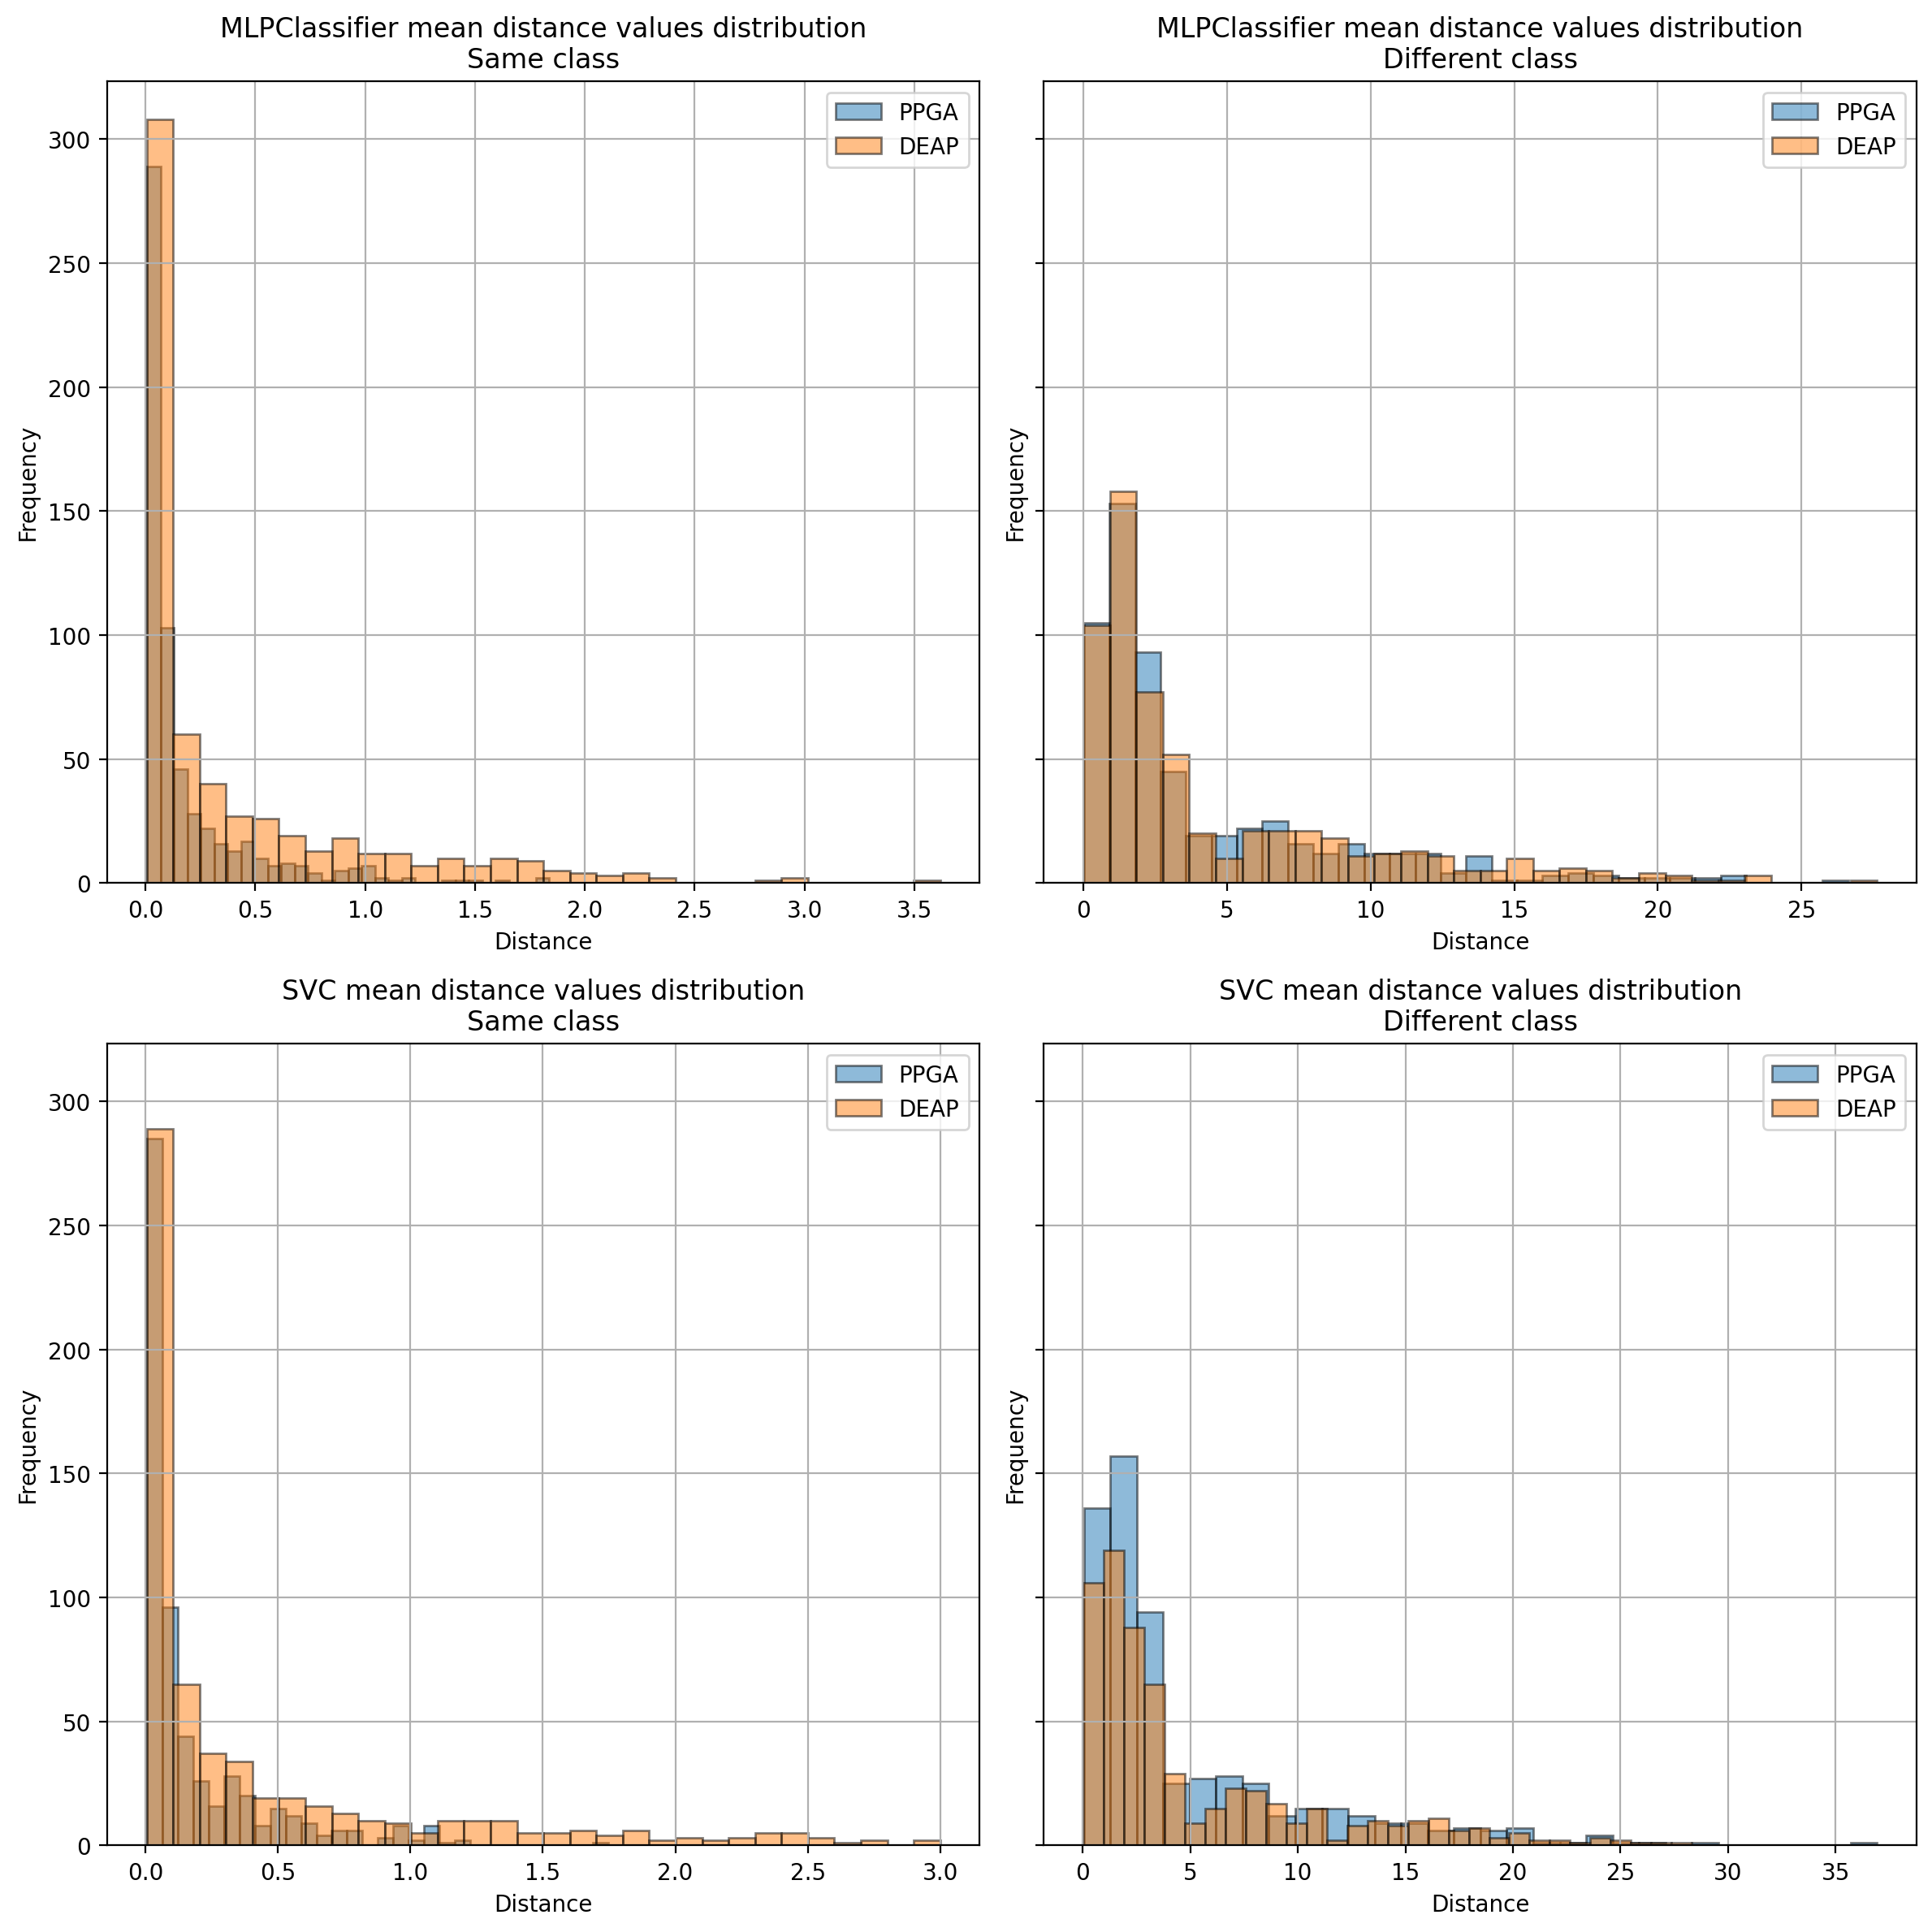

In [32]:
import matplotlib.pyplot as plt


def plot_distance_distribution(df1: pd.DataFrame, df2: pd.DataFrame):
    models = ppga_df["model"].unique()

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 12), dpi=200)

    for i, model in enumerate(models):
        mask = (ppga_df["model"] == model) & (ppga_df["class"] == ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()

        mask = (deap_df["model"] == model) & (deap_df["class"] == deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()

        axes[i][0].set_title(f"{model} mean distance values distribution\nSame class")
        axes[i][0].set_xlabel("Distance")
        axes[i][0].set_ylabel("Frequency")
        axes[i][0].hist(ppga_dist, bins=30, edgecolor="black", alpha=0.5, label="PPGA")
        axes[i][0].hist(deap_dist, bins=30, edgecolor="black", alpha=0.5, label="DEAP")
        axes[i][0].legend()
        axes[i][0].grid(True)

        mask = (ppga_df["model"] == model) & (ppga_df["class"] != ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()

        mask = (deap_df["model"] == model) & (deap_df["class"] != deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()

        axes[i][1].set_title(
            f"{model} mean distance values distribution\nDifferent class"
        )
        axes[i][1].set_xlabel("Distance")
        axes[i][1].set_ylabel("Frequency")
        axes[i][1].hist(ppga_dist, bins=30, edgecolor="black", alpha=0.5, label="PPGA")
        axes[i][1].hist(deap_dist, bins=30, edgecolor="black", alpha=0.5, label="DEAP")
        axes[i][1].legend()
        axes[i][1].grid(True)

    plt.tight_layout()
    plt.show()


plot_distance_distribution(ppga_df, deap_df)

Per un'analisi più granulare sono stati ordinati in ordine crescente tutti i
valori di distanza media ottenuti con PPGA tramite la funzione `argsort` di
Numpy. Con gli indici generati sono stati ordinati i valori di distanza ottenuti
con DEAP.

I grafici di seguito dispongono in ordine crescente i valori di distanza di PPGA
e mettono sulla stessa coordinata $x$ il corrispondente valore di distanza
ottenuto con DEAP. In questo modo è possibile confrontare il valor medio di
distanza ottenuto per ogni esecuzione.


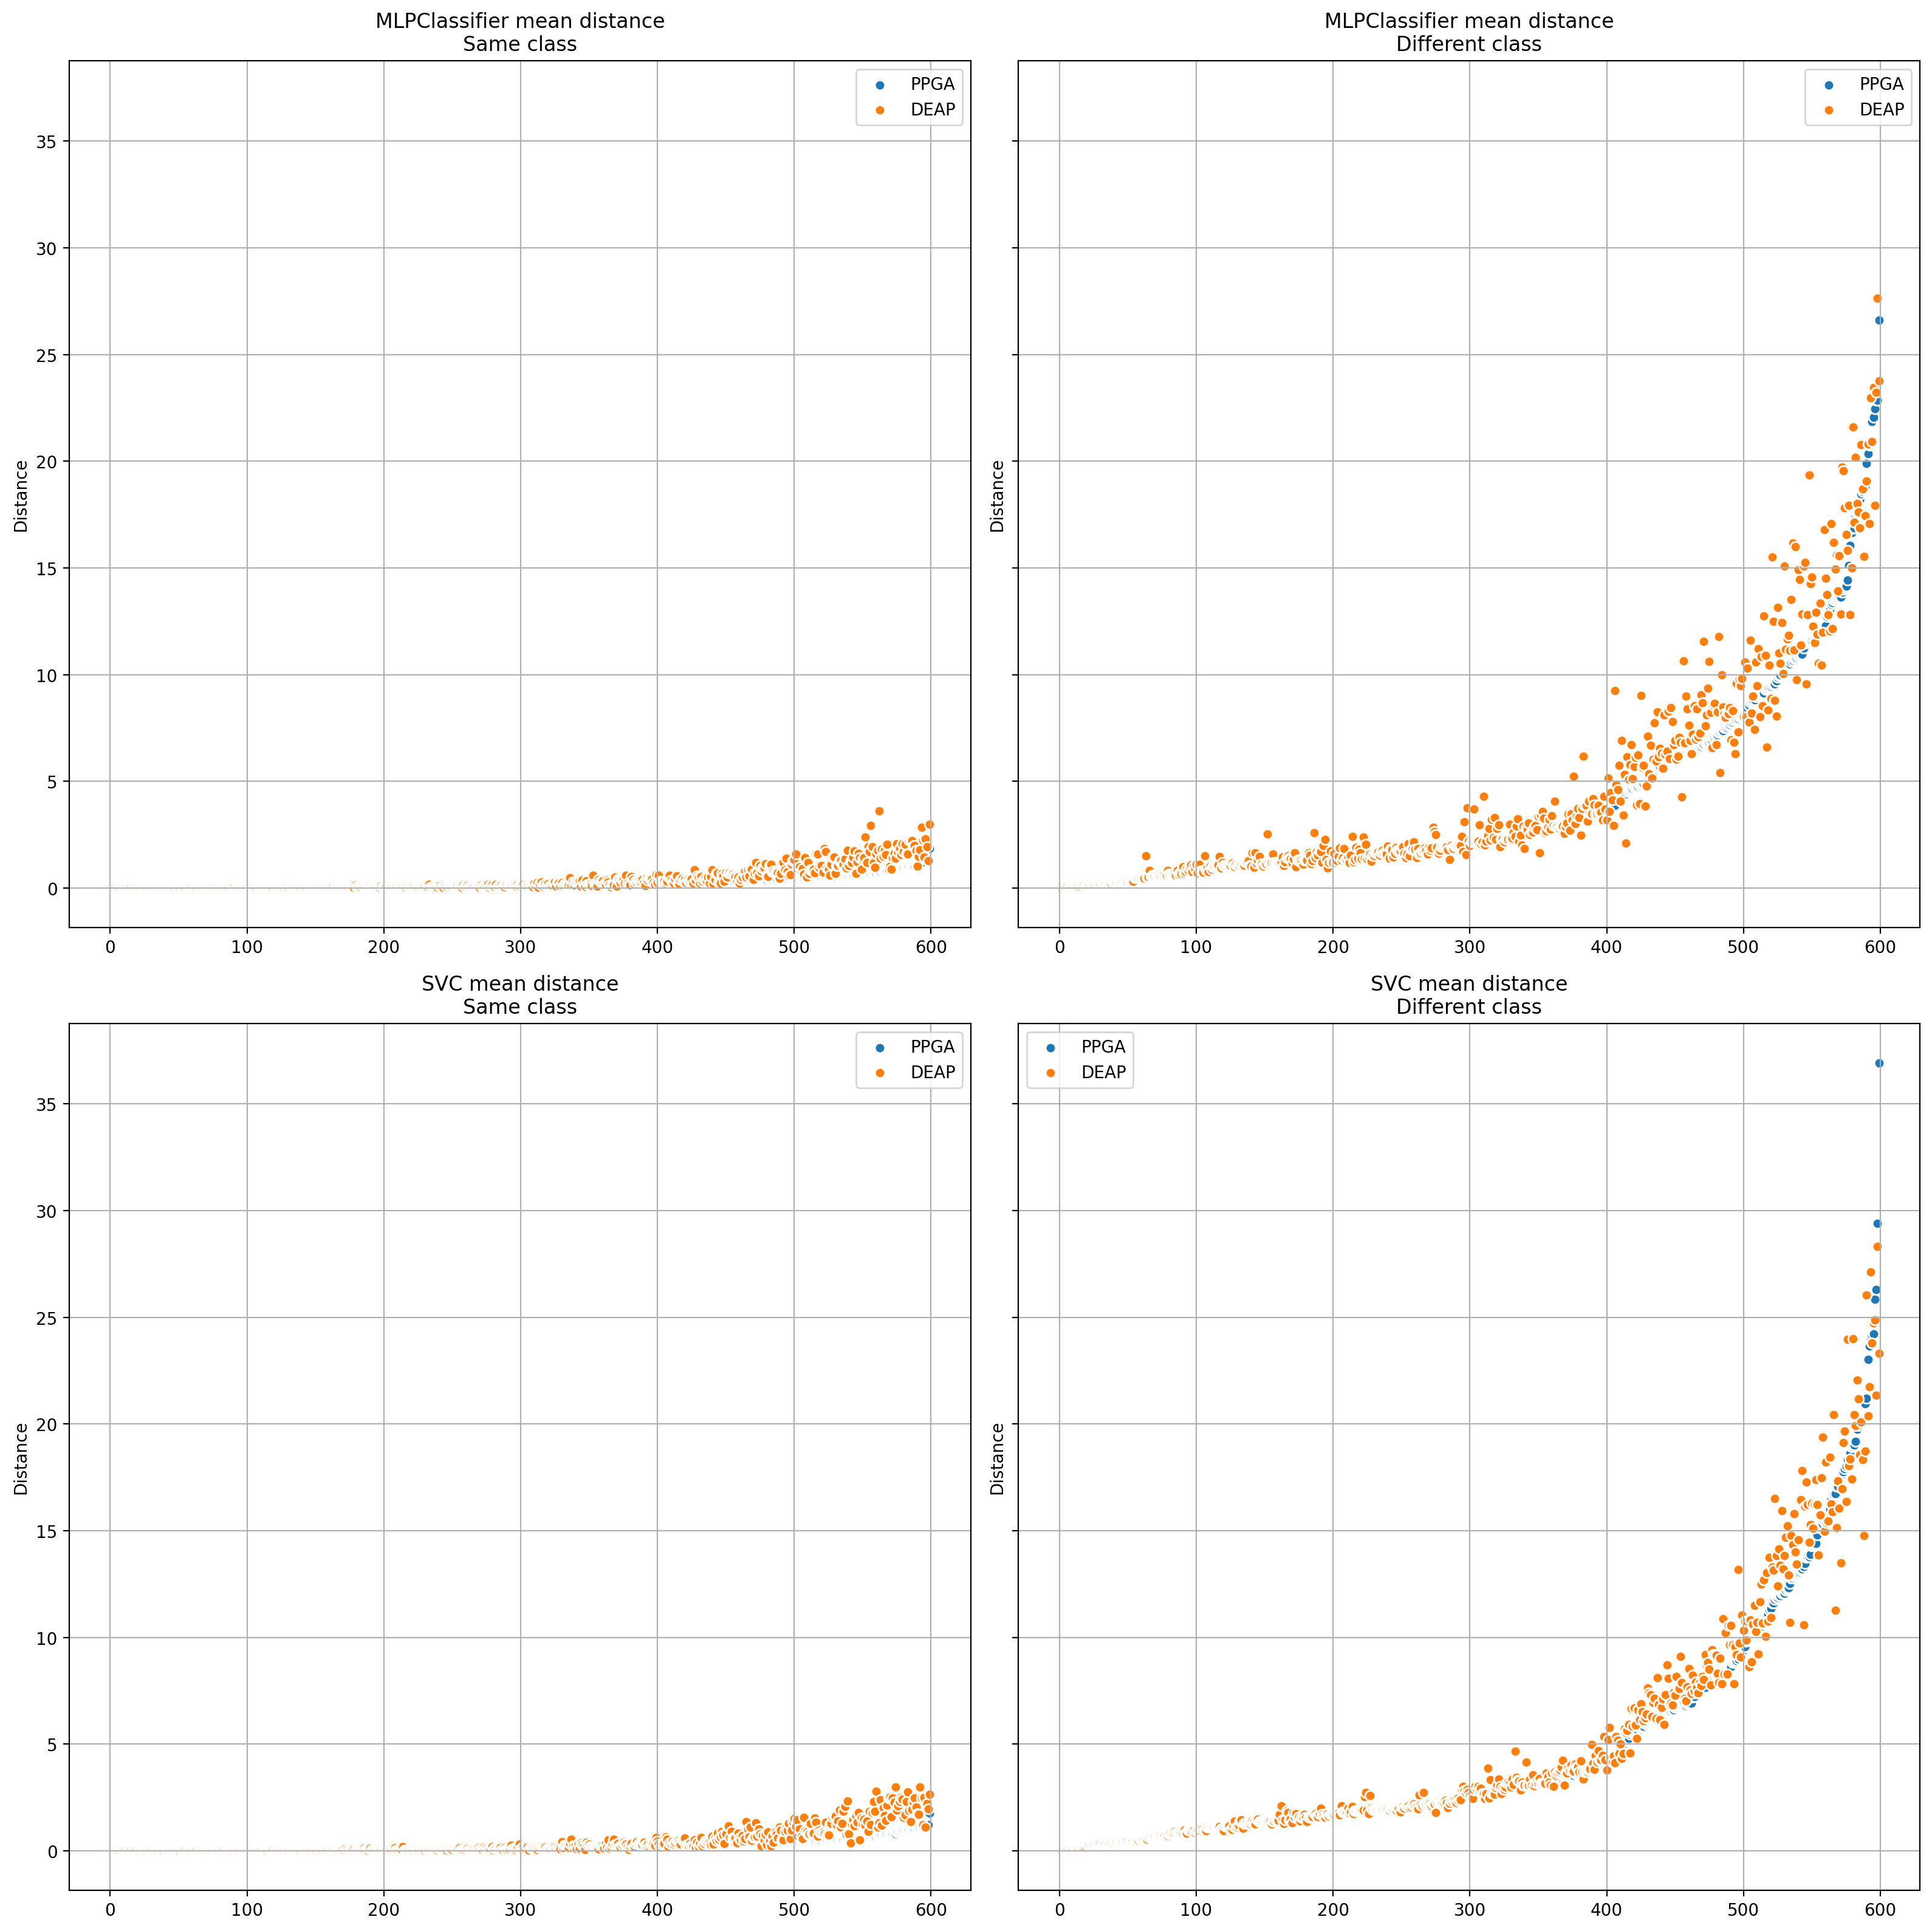

In [33]:
import numpy as np


def plot_distance_trend(df1: pd.DataFrame, df2: pd.DataFrame):
    models = ppga_df["model"].unique()

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(16, 16), dpi=200)

    for i, model in enumerate(models):
        mask = (ppga_df["model"] == model) & (ppga_df["class"] == ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()

        indices = np.argsort(ppga_dist)
        ppga_dist = ppga_dist[indices]

        mask = (deap_df["model"] == model) & (deap_df["class"] == deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()
        deap_dist = deap_dist[indices]

        x = [i for i in range(len(ppga_dist))]
        axes[i][0].set_title(f"{model} mean distance\nSame class")
        axes[i][0].set_ylabel("Distance")
        axes[i][0].scatter(x, ppga_dist, ec="w", label="PPGA")
        axes[i][0].scatter(x, deap_dist, ec="w", label="DEAP")
        axes[i][0].legend()
        axes[i][0].grid(True)

        mask = (ppga_df["model"] == model) & (ppga_df["class"] != ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()

        indices = np.argsort(ppga_dist)
        ppga_dist = ppga_dist[indices]

        mask = (deap_df["model"] == model) & (deap_df["class"] != deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()
        deap_dist = deap_dist[indices]

        axes[i][1].set_title(f"{model} mean distance\nDifferent class")
        axes[i][1].set_ylabel("Distance")
        axes[i][1].scatter(x, ppga_dist, ec="w", label="PPGA")
        axes[i][1].scatter(x, deap_dist, ec="w", label="DEAP")
        axes[i][1].legend()
        axes[i][1].grid(True)

    plt.tight_layout()
    plt.show()


plot_distance_trend(ppga_df, deap_df)

## Numero di individui sintetici variabile

Di seguito lo studio dell'andamento del valore medio di distanza ottenuto per
le due librerie, al variare del numero di individui sintetici generati. Come
prima considerando prima solo le esecuzioni con classe target uguale alla classe
del punto considerato e poi con classe target differente.

In questo caso i risultati ottenuti su punti dello stesso dataset sono stati
aggregati tramite la media dei valori medi ottenuti.


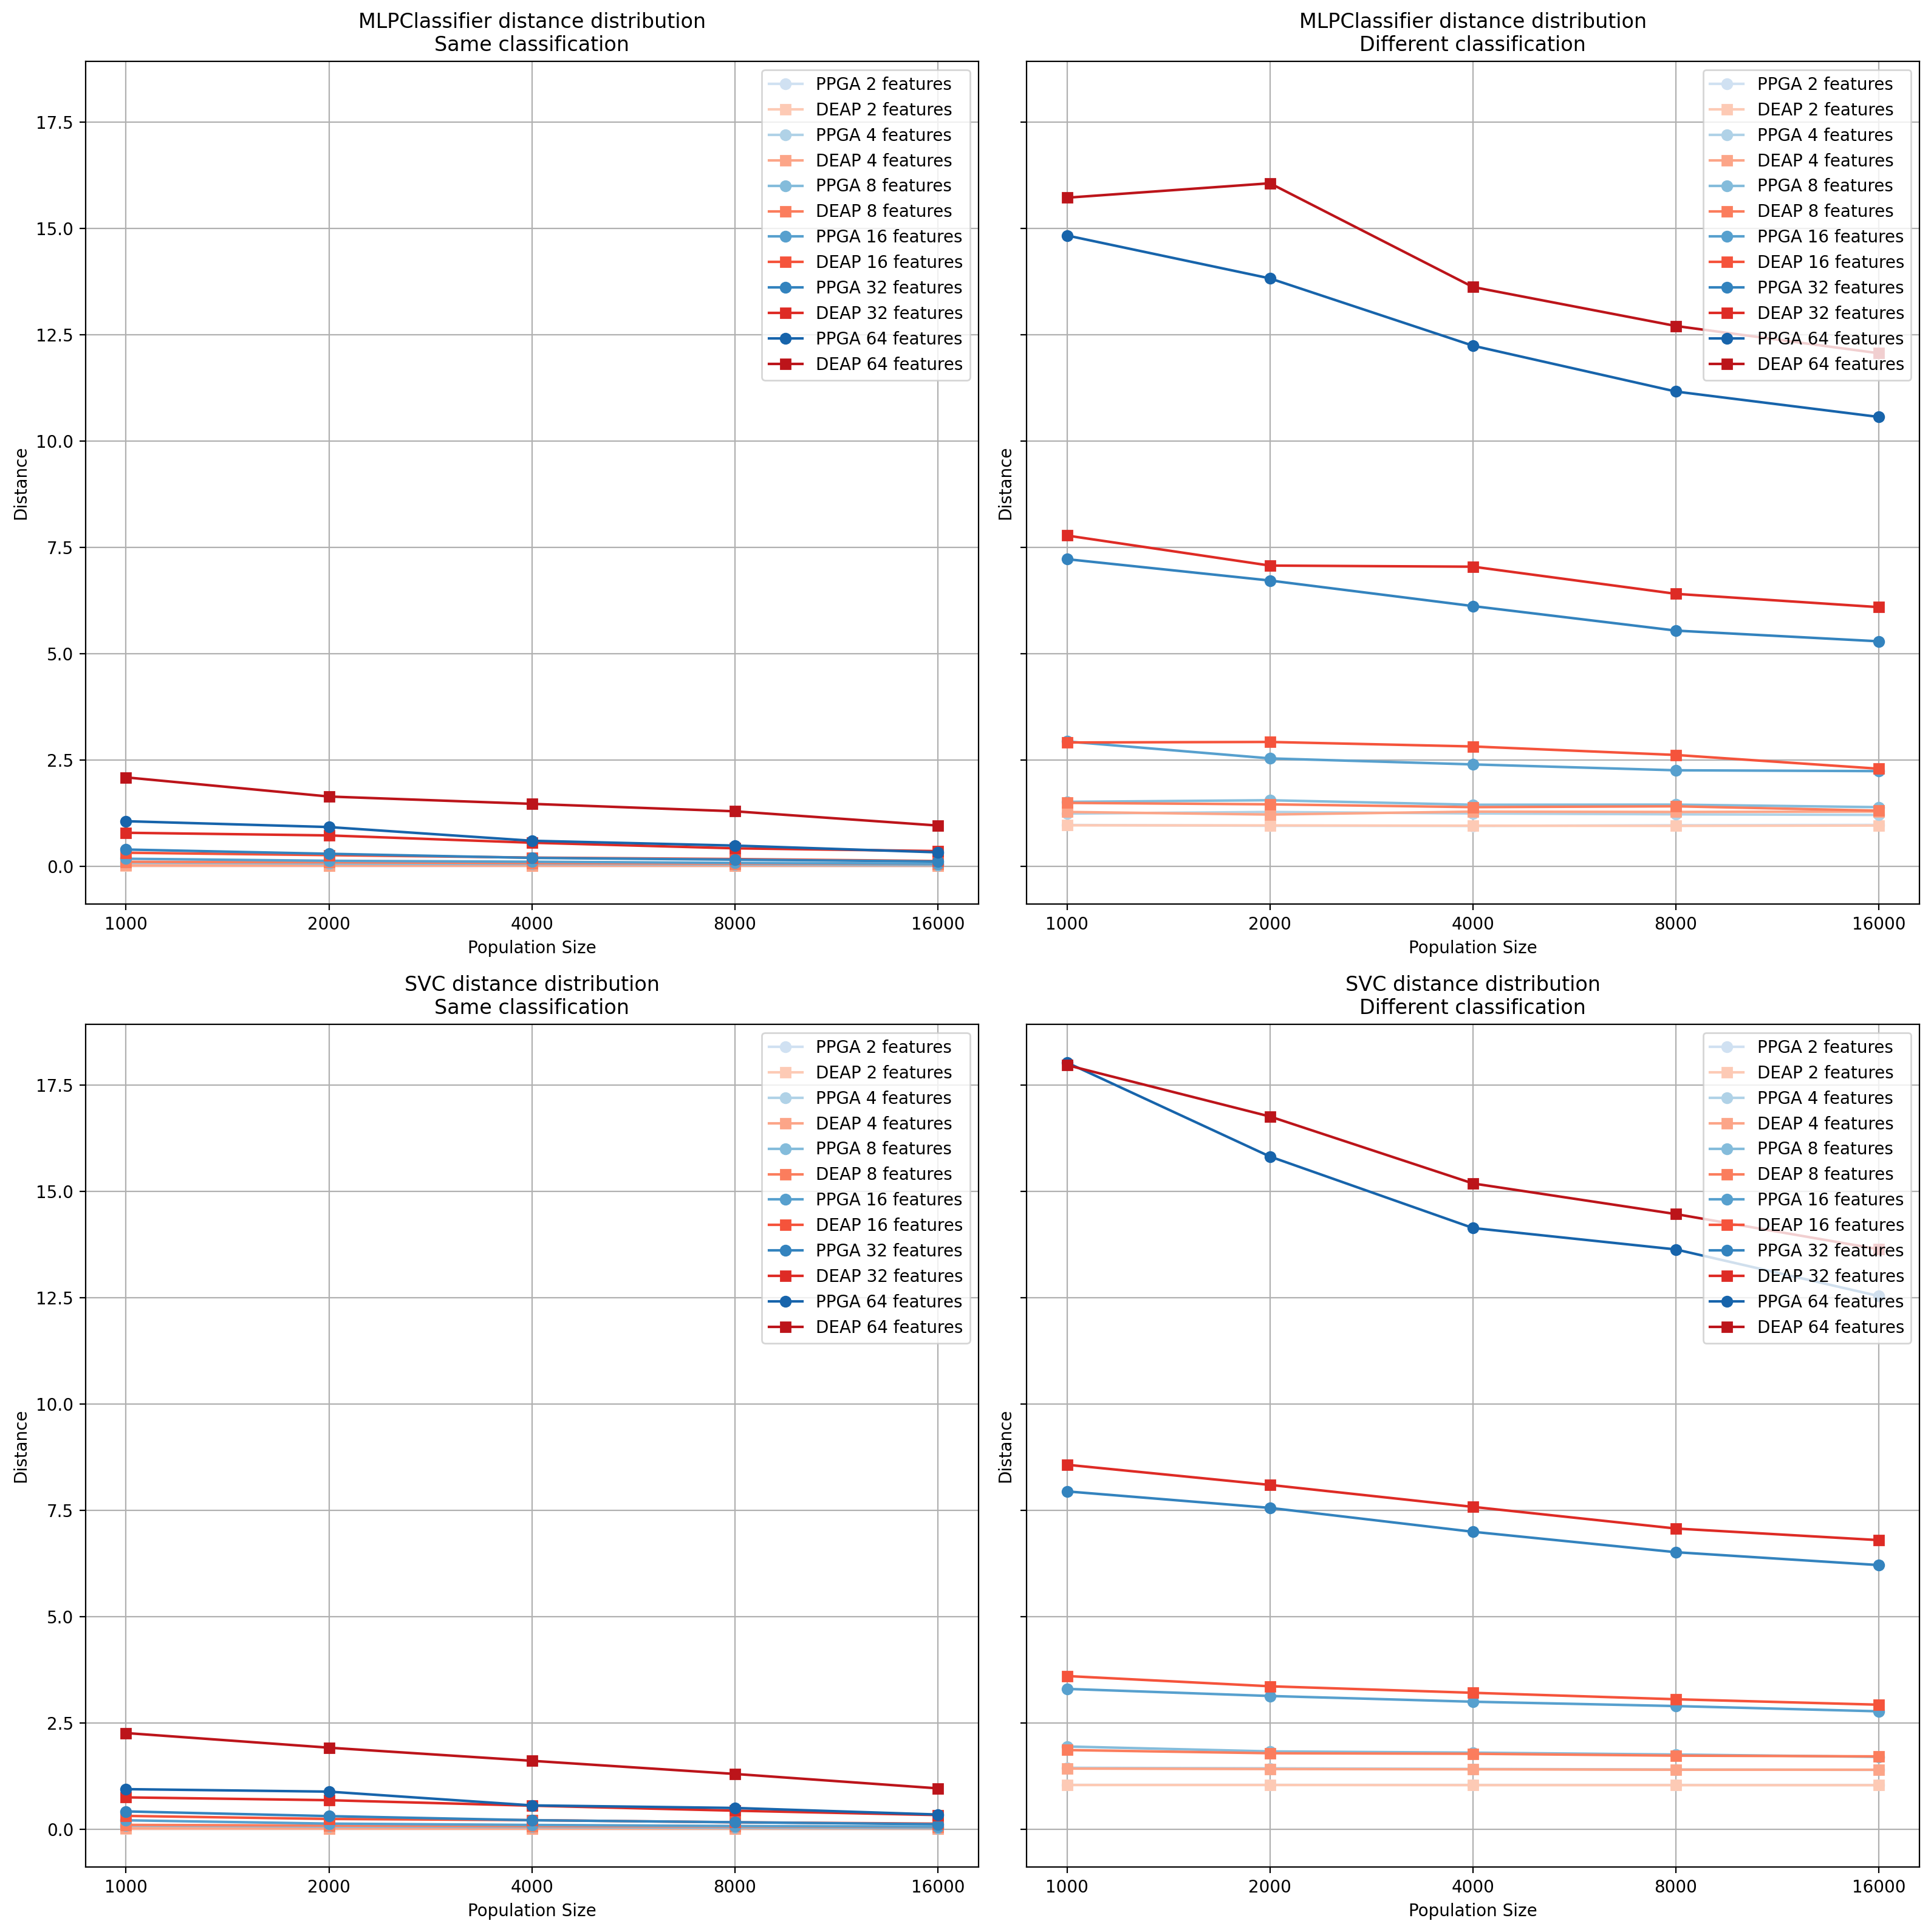

In [34]:
import operator


def plot_mean_distance_popsize(df1: pd.DataFrame, df2: pd.DataFrame):
    models = df1["model"].unique()
    features = df1["features"].unique()
    # features = [16, 32, 64]

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(16, 16), dpi=200)
    ppga_color = plt.cm.Blues(np.linspace(0.2, 0.8, len(features)))
    deap_color = plt.cm.Reds(np.linspace(0.2, 0.8, len(features)))

    def plot_target(df1: pd.DataFrame, df2: pd.DataFrame, op):
        col = 0 if op is operator.eq else 1
        target = "Same" if col == 0 else "Different"

        # PPGA
        temp_df1 = df1[op(df1["class"], df1["target"])]
        temp_df1 = (
            temp_df1.groupby(["model", "features", "population_size"])[
                ["mean_distance", "distance_std"]
            ]
            .mean()
            .reset_index()
        )

        # DEAP
        temp_df2 = df2[op(df2["class"], df2["target"])]
        temp_df2 = (
            temp_df2.groupby(["model", "features", "population_size"])[
                ["mean_distance", "distance_std"]
            ]
            .mean()
            .reset_index()
        )

        for i, model in enumerate(models):
            for j, f in enumerate(features):
                # PPGA
                mask = (temp_df1["model"] == model) & (temp_df1["features"] == f)
                x = temp_df1[mask]["population_size"]
                y = temp_df1[mask]["mean_distance"]

                axes[i][col].plot(
                    x, y, color=ppga_color[j], marker="o", label=f"PPGA {f} features"
                )

                # DEAP
                mask = (temp_df2["model"] == model) & (temp_df2["features"] == f)
                x = temp_df2[mask]["population_size"]
                y = temp_df2[mask]["mean_distance"]

                axes[i][col].plot(
                    x, y, color=deap_color[j], marker="s", label=f"DEAP {f} features"
                )

                # tweaks
                axes[i][col].set_title(
                    f"{model} distance distribution\n{target} classification"
                )
                axes[i][col].set_xlabel("Population Size")
                axes[i][col].set_ylabel("Distance")
                axes[i][col].set_xscale("log", base=2)
                axes[i][col].set_xticks(
                    df1["population_size"].unique(),
                    labels=df1["population_size"].unique(),
                )
                axes[i][col].grid(True)
                axes[i][col].legend()

    plot_target(df1, df2, operator.eq)
    plot_target(df1, df2, operator.ne)

    plt.tight_layout()
    plt.show()


plot_mean_distance_popsize(ppga_df, deap_df)

## Numero di feature variabile

In modo simile analizziamo l'andamento della distanza media al variare del
numero di feature.


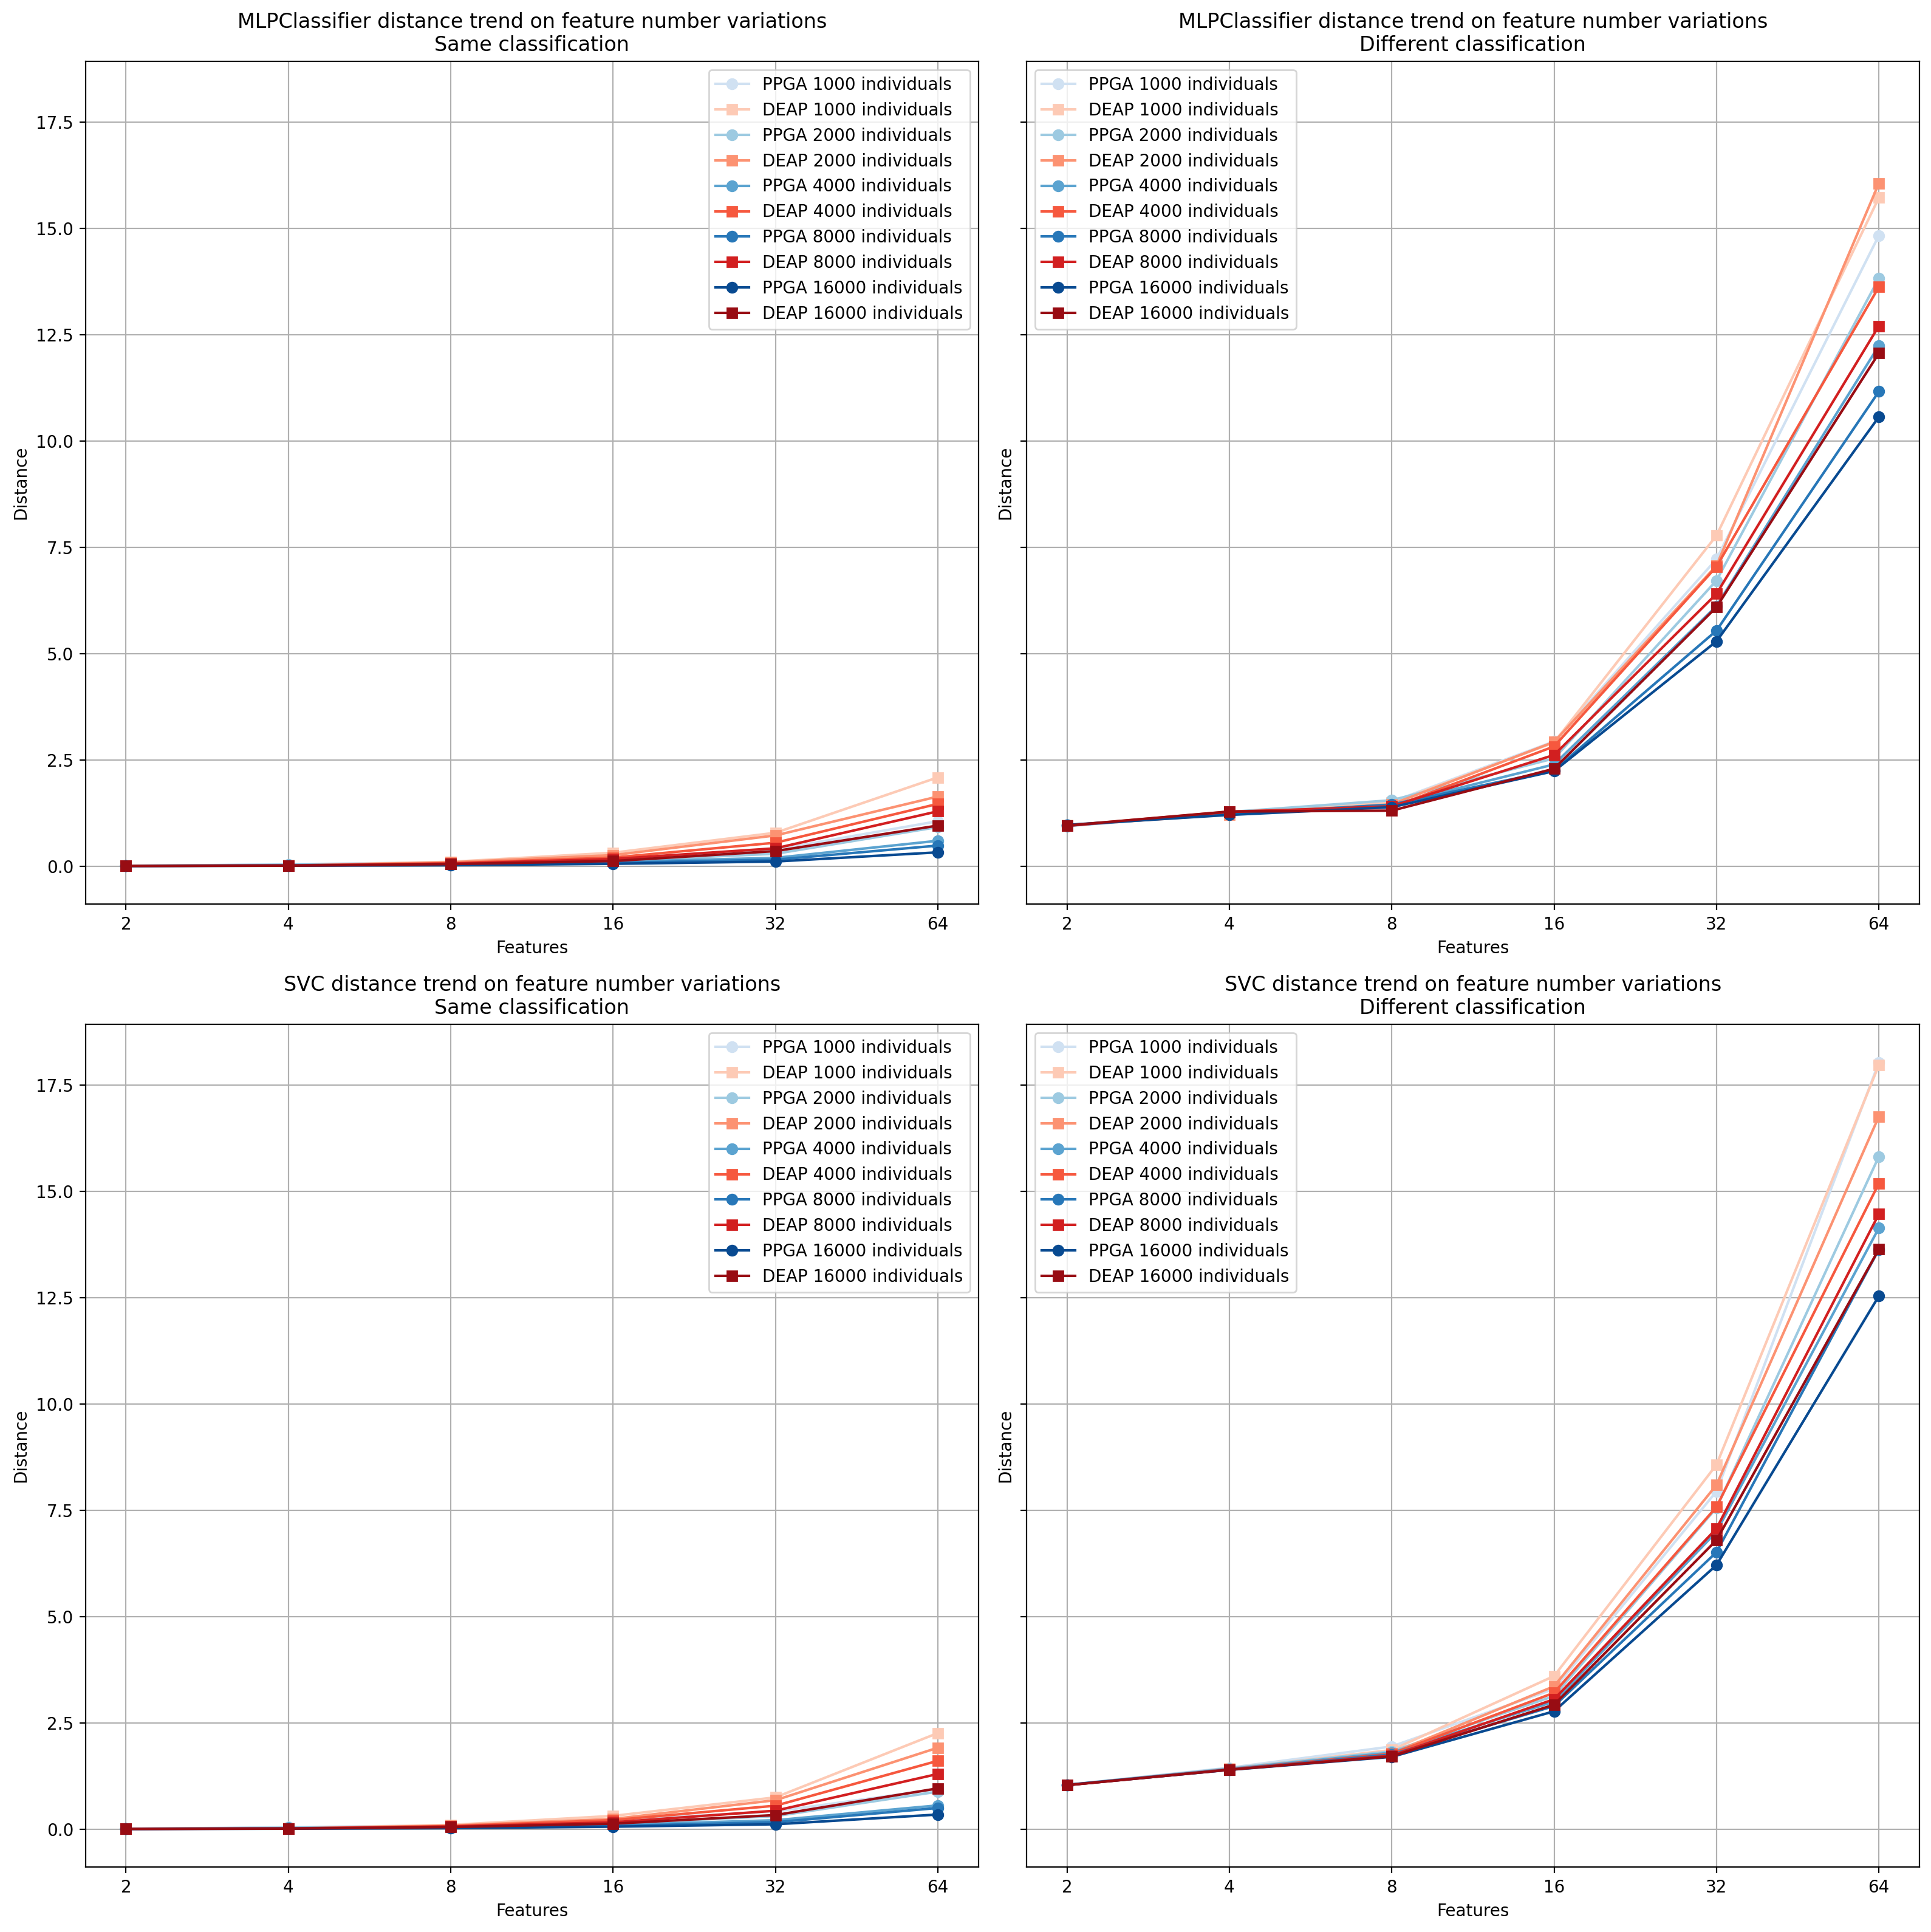

In [35]:
def plot_mean_distance_feature(df1: pd.DataFrame, df2: pd.DataFrame):
    models = df1["model"].unique()
    sizes = df1["population_size"].unique()
    # sizes = [4000, 8000, 16000]

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(16, 16), dpi=200)
    ppga_color = plt.cm.Blues(np.linspace(0.2, 0.9, len(sizes)))
    deap_color = plt.cm.Reds(np.linspace(0.2, 0.9, len(sizes)))

    def plot_target(df1: pd.DataFrame, df2: pd.DataFrame, op):
        col = 0 if op is operator.eq else 1
        target = "Same" if col == 0 else "Different"

        temp_df1 = df1[op(df1["class"], df1["target"])]
        temp_df1 = (
            temp_df1.groupby(["model", "features", "population_size"])["mean_distance"]
            .mean()
            .reset_index()
        )
        temp_df2 = df2[op(df2["class"], df2["target"])]
        temp_df2 = (
            temp_df2.groupby(["model", "features", "population_size"])["mean_distance"]
            .mean()
            .reset_index()
        )

        for i, model in enumerate(models):
            for j, s in enumerate(sizes):
                axes[i][col].set_title(
                    f"{model} distance trend on feature number variations\n{target} classification"
                )
                axes[i][col].set_xlabel("Features")
                axes[i][col].set_ylabel("Distance")

                # PPGA curves
                mask = (temp_df1["model"] == model) & (temp_df1["population_size"] == s)
                x = temp_df1[mask]["features"]
                y = temp_df1[mask]["mean_distance"]
                axes[i][col].plot(
                    x, y, color=ppga_color[j], marker="o", label=f"PPGA {s} individuals"
                )

                # DEAP curves
                mask = (temp_df2["model"] == model) & (temp_df2["population_size"] == s)
                x = temp_df2[mask]["features"]
                y = temp_df2[mask]["mean_distance"]
                axes[i][col].plot(
                    x, y, color=deap_color[j], marker="s", label=f"DEAP {s} individuals"
                )

                # tweaks
                axes[i][col].set_xscale("log", base=2)
                axes[i][col].set_xticks(
                    df1["features"].unique(), labels=df1["features"].unique()
                )

                axes[i][col].grid(True)
                axes[i][col].legend()

    plot_target(df1, df2, operator.eq)
    plot_target(df1, df2, operator.ne)

    plt.tight_layout()
    plt.show()


plot_mean_distance_feature(ppga_df, deap_df)

# Parallelismo e qualità delle soluzioni

Prima di concludere si vuole evidenziare alcune possibili criticità quando si
lavora con la versione parallela della libreria. A differenza di DEAP, che
parallelizza solo la fase di valutazione, questa parallelizza anche le fasi di
crossover, mutazione.

Durante la fase di test sono infatti emerse alcune criticità riguardanti tali
operatori, che in contesto di calcolo parallelo potrebbero portare a
comportamenti inattesi.

### Crossover

Dato che la genereazione della popolazione iniziale avviene per copia, la
diversità genetica iniziale è pari a zero. Per un algoritmo genetico, questo
è in generale un problema dato che sfrutta meccanismi come il crossover per
ricombinare i cromosomi tra individui diversi.

Nel nostro caso partiamo però da una situazione in cui tutti gli individui sono
cloni e utilizziamo metodi di crossover come quello a singolo o doppio punto di
crossover, che non producono nuovi valori per le feature ma si limitano ad
esplorare e ricombinare i valori già esistenti.

Ne segue che l'applicazione del crossover tra due cloni risulterà nella
generazione di altri due cloni identici tra di loro e ai loro genitori.

### Mutazione

Per le prime iterazioni ci si affida quindi all'operatore di mutazione come
unico meccanismo per introdurre diversità genetica. Il problema è che la
mutazione ha generalmente una probabilità bassa di essere applicata (in genere
20/30%). Se aggiungiamo poi che ogni feature ha una probabilità indipendente di
essere modificata, la probabilità che un individuo scelto per la mutazione,
venga effettivamente modificato, cala ulteriormente.

Quando partizioniamo la popolazione tra molti worker si potrebbe andare
incontro ad un problema nel caso in cui il rapporto

$$\frac{N}{W}$$

dove $N$ è il numero di individui e $W$ è il numero di worker, è troppo basso.
Si rischia che i worker mutino pochi individui o nessuno, lasciando la
diversità genetica bassa per diverse iterazioni.

Per evitare che ciò accada è necessario che la probabilità indipendente sia
abbastanza alta, ma soprattutto che il numero di individui assegnato ad ogni
worker sia sufficientemente elevato.

### Seme di casualità

Dato che le fasi di crossover e mutazione fanno leva sulla generazione di
numeri casuali, è necessario fare alcune considerazioni. Il **seme** di
casualità deve essere inizializzato per ogni worker in modo da essere sicuri
che sia diverso. Se non inizializzato esplicitamente verrà usata la funzione
`time.time()`, la quale ha una risoluzione dell'ordine dei secondi.

Ne seguirebbe che ogni worker è inizializzato quasi sicuramente con lo stesso
seed e quindi muta gli stessi individui allo stesso modo degli altri worker.
Andiamo quindi a creare $W$ sottopopolazioni tutte identiche tra di loro.

La libreria inizializza i generatori di numeri casuali sia del modulo `random`
di Python, sia di `numpy`.


In [43]:
deap2 = pd.read_csv("../results/quality/deap2.csv")
deap2 = deap2[deap2["model"] == "RandomForestClassifier"]
deap2 = deap2[deap2["population_size"] == 1000].reset_index(drop=True)
deap2

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,4,2,1,1,1000,0,0,0,RandomForestClassifier,0.029769,0.014389,0.009180,0.000487,1.0
1,10,4,2,1,1,1000,0,0,1,RandomForestClassifier,2.199825,2.197762,0.001425,2.194748,1.0
2,10,4,2,1,1,1000,1,0,0,RandomForestClassifier,0.041096,0.022617,0.011283,0.003156,1.0
3,10,4,2,1,1,1000,1,0,1,RandomForestClassifier,0.330680,0.311501,0.012658,0.294211,1.0
4,10,4,2,1,1,1000,2,1,0,RandomForestClassifier,0.474543,0.463936,0.005979,0.453888,1.0
5,10,4,2,1,1,1000,2,1,1,RandomForestClassifier,0.066610,0.033290,0.017679,0.000790,1.0
6,10,4,2,1,1,1000,3,0,0,RandomForestClassifier,0.049599,0.026594,0.013439,0.003616,1.0
7,10,4,2,1,1,1000,3,0,1,RandomForestClassifier,0.193215,0.146520,0.026330,0.103078,1.0
8,10,4,2,1,1,1000,4,0,0,RandomForestClassifier,0.038086,0.020131,0.010160,0.002487,1.0
9,10,4,2,1,1,1000,4,0,1,RandomForestClassifier,1.446765,1.428474,0.011448,1.408813,1.0


In [45]:
deap_rf = pd.read_csv("../results/deap_RandomForestClassifier_added.csv")
deap_rf = deap_rf[deap_rf["population_size"] == 1000]
deap_rf = deap_rf[
    (deap_rf["features"] == 32)
    | (deap_rf["features"] == 8)
    | (deap_rf["features"] == 4)
]
deap_rf = deap_rf[deap_rf["seed"] == 1].reset_index(drop=True)
deap_rf[["min_fitness", "mean_fitness", "max_fitness"]] *= -1.0
deap_rf = deap_rf.rename(
    columns={
        "min_fitness": "max_distance",
        "mean_fitness": "mean_distance",
        "fitness_std": "distance_std",
        "max_fitness": "min_distance",
    }
)

deap_rf = deap_rf.sort_values(by=["features", "point", "class", "target"]).reset_index(
    drop=True
)

deap_rf

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,4,2,1,1,1000,0,0,0,RandomForestClassifier,0.029769,0.014389,0.009180,0.000487,1.0
1,10,4,2,1,1,1000,0,0,1,RandomForestClassifier,2.199825,2.197762,0.001425,2.194748,1.0
2,10,4,2,1,1,1000,1,0,0,RandomForestClassifier,0.041096,0.022617,0.011283,0.003156,1.0
3,10,4,2,1,1,1000,1,0,1,RandomForestClassifier,0.330680,0.311501,0.012658,0.294211,1.0
4,10,4,2,1,1,1000,2,1,0,RandomForestClassifier,0.474543,0.463936,0.005979,0.453888,1.0
5,10,4,2,1,1,1000,2,1,1,RandomForestClassifier,0.066610,0.033290,0.017679,0.000790,1.0
6,10,4,2,1,1,1000,3,0,0,RandomForestClassifier,0.049599,0.026594,0.013439,0.003616,1.0
7,10,4,2,1,1,1000,3,0,1,RandomForestClassifier,0.193215,0.146520,0.026330,0.103078,1.0
8,10,4,2,1,1,1000,4,0,0,RandomForestClassifier,0.038086,0.020131,0.010160,0.002487,1.0
9,10,4,2,1,1,1000,4,0,1,RandomForestClassifier,1.446765,1.428474,0.011448,1.408813,1.0
